# Prepare Data

In [35]:
import tensorflow as tf
import cv2

from numba import cuda 

from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input, Softmax, Conv1D, MaxPooling1D
from keras.engine.saving import model_from_json
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model
from keras_preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from skimage.restoration import denoise_wavelet

from pathlib import Path

from google.colab import files
from google.colab import drive

import os
import sys

import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

import librosa
import librosa.display

In [3]:
drive.mount('/content/gdrive', force_remount=True)
iemocap = "gdrive/My Drive/Public/IEMOCAP_full_release"

print("GPU Name: ", tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Mounted at /content/gdrive
GPU Name:  /device:GPU:0
Num GPUs Available:  1


# Convert into CSV

In [4]:
sessions = ["Session1", "Session2", "Session3", "Session4", "Session5"]

def convertSession(session_name):
  session_file = iemocap + "/Duration/Processed/" + session_name + ".txt"
  tokenized_lines = []

  with open(session_file) as f:
    lines = f.readlines()
    tokenizedLines = [x.split() for x in lines]

  session_csv = iemocap + "/Duration/Processed/" + session_name + ".csv"
  with open(session_csv, "w") as csv:
    audio_name = ''

    for line in tokenizedLines:
      if line[0] == "Recording":
        audio_name = line[1]
      else:
        csv.write(audio_name + ";" + line[0] + ";" + line[1] + "\n")

def convertRawToCsv():
  for session in sessions:
    convertSession(session)

# convertRawToCsv()

# Convert into data frame

In [5]:
def getSessionData(session_name):
  df = pd.read_csv(iemocap + "/Duration/Processed/" + session_name + ".csv", delimiter=";", header=None)
  df.columns = ["Audio Name", "Part", "Duration"]
  print(session_name + " count: " + str(len(df.index)))

  return df

def getDataFrame():
  result = pd.DataFrame()

  for session in sessions:
    df = getSessionData(session)
    result = result.append(df, ignore_index=True)

  return result

result = getDataFrame()
result["Duration"] = result["Duration"].apply(np.floor).astype(int)
result

Session1 count: 1819
Session2 count: 1811
Session3 count: 2136
Session4 count: 2103
Session5 count: 2170


,Audio Name,Part,Duration
0,Ses01F_impro01,F000,1
1,Ses01F_impro01,F001,1
2,Ses01F_impro01,F002,3
3,Ses01F_impro01,F003,1
4,Ses01F_impro01,F004,3
...,...,...,...
10034,Ses05M_script03_2,M041,8
10035,Ses05M_script03_2,M042,1
10036,Ses05M_script03_2,M043,2
10037,Ses05M_script03_2,M044,4


# Plot

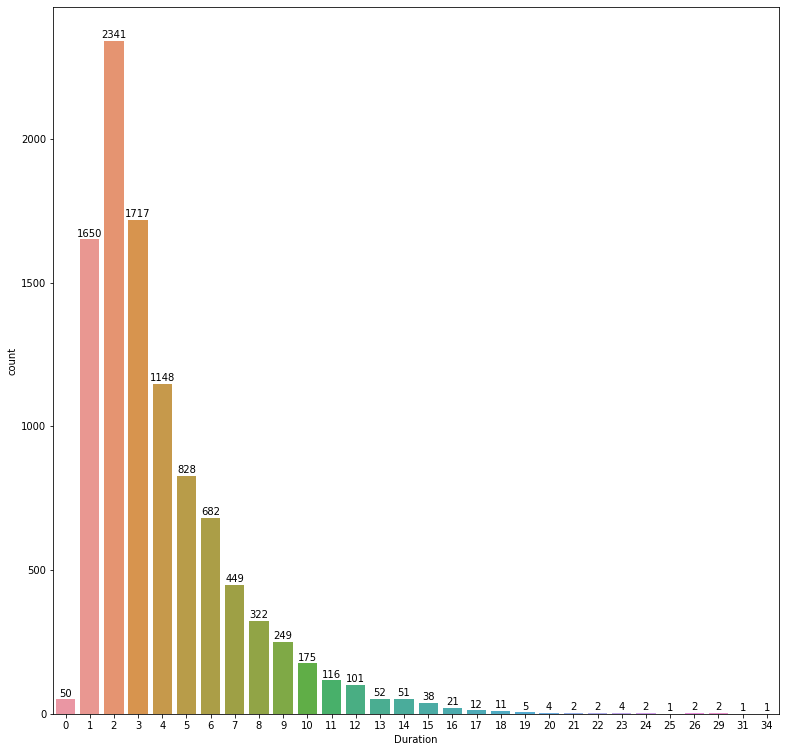

In [ ]:
plot = seaborn.countplot(x='Duration', data=result)
plot.figure.set_size_inches(13,13)

for p in plot.patches:
  height = p.get_height()
  plot.text(p.get_x() + p.get_width()/2., height + 10, '{:1.0f}'.format(height), ha="center") 

In [ ]:
print("Original data: " + str(result.count()))

count_data = result.value_counts(subset=['Duration'], sort=False).values
count_normalize = result.value_counts(subset=['Duration'], sort=False, normalize=True).values
duration = sorted(result.Duration.unique())

count_df = pd.DataFrame({"Duration": duration, "Count": count_data, "Percentage": count_normalize})
count_df.Percentage = (count_df.Percentage * 100).round(3)

Original data: Audio Name     10039
Part           10039
Duration       10039
Evaluation1        0
Evaluation2        0
Evaluation3        0
Evaluation4        0
Evaluation5        0
Evaluation6        0
Emotion        10039
dtype: int64


,Duration,Count,Percentage
0,0,50,0.498
1,1,1650,16.436
2,2,2341,23.319
3,3,1717,17.103
4,4,1148,11.435
5,5,828,8.248
6,6,682,6.794
7,7,449,4.473
8,8,322,3.207
9,9,249,2.480


# Labeling

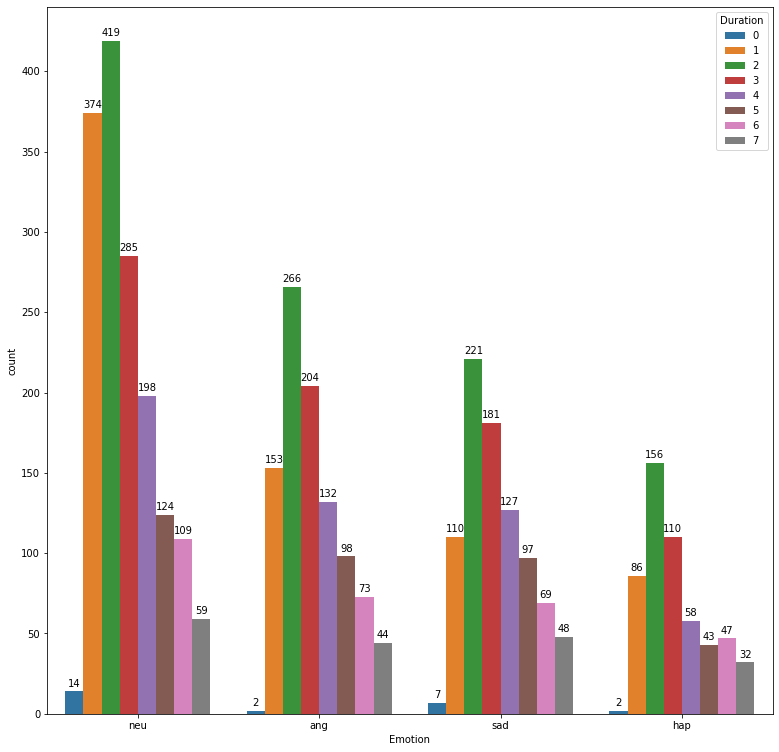

In [6]:
def resetEvaluation():
  result["Emotion"] = None

def goLabeling():
  for session in sessions:
    emotion_path = iemocap + "/" + session + "/dialog/EmoEvaluation/"

    recordings = [file.name for file in os.scandir(emotion_path) if ".txt" in file.name]
    recordings.sort()
    
    for recording in recordings:
      with open(emotion_path + recording) as f:
        lines = f.readlines()
        tokenizedLines = [x.split() for x in lines if "Ses0" in x]

        for part in tokenizedLines:
          line_name = part[3]
          line_label = part[4]
          line_queries = line_name.split("_")
          
          line_part = line_queries[-1]
          line_queries.remove(line_part)

          line_name = "_".join(line_queries)

          search_query_name = ""
          search_query_part = line_queries[-1]
          search_result = result.loc[(result["Audio Name"] == line_name) & (result["Part"] == line_part), "Emotion"]
          search_count = search_result.shape[0]
          
          if search_count == 0:
            print("ERROR: No audio part found: ")
          elif search_count > 1:
            print("ERROR: Multiple audio found: ")
          else:
            result.loc[(result["Audio Name"] == line_name) & (result["Part"] == line_part), "Emotion"] = line_label

def getClassificationReport():
  max_duration = 7

  categorical_data = result.loc[
    (result["Duration"] < max_duration + 1) &
    (
      (result["Emotion"] == 'neu') |
      (result["Emotion"] == 'ang') |
      (result["Emotion"] == 'hap') |
      (result["Emotion"] == 'sad') 
    )
  ]
  
  categorical_plot = seaborn.countplot(x="Emotion", hue="Duration", data=categorical_data)
  categorical_plot.figure.set_size_inches(13,13)

  for p in categorical_plot.patches:
    height = p.get_height()
    categorical_plot.text(p.get_x() + p.get_width()/2., height + 3, '{:1.0f}'.format(height), ha="center") 

  return categorical_data

resetEvaluation()
goLabeling()
categorical_data = getClassificationReport()

# Selection and Splitting

In [48]:
def checkAndCreateDirectory(filename):
  if not os.path.exists(os.path.dirname(filename)):
    try:
        os.makedirs(os.path.dirname(filename))
    except OSError as exc: # Guard against race condition
        print(exc.errno)
        if exc.errno != errno.EEXIST:
            raise

def getMfccValue(audio_path, row, dataset_type):
  audio_file, sample_rate = librosa.load(audio_path)
  audio_file = denoise_wavelet(audio_file, method='VisuShrink', rescale_sigma=True)

  S = librosa.feature.melspectrogram(y=audio_file, sr=48000)
  S[S < (np.average(S) / 1)] = 0.0

  librosa.display.specshow(librosa.power_to_db(S, ref=np.max))

  filename = "image/" + dataset_type + "/" + row["Emotion"] + "/" + row["Audio Name"] + "_" + row["Part"] + '.png'
  checkAndCreateDirectory(filename)

  plt.gca().set_axis_off()
  plt.savefig(filename, dpi=100, bbox_inches='tight',pad_inches=0)
  # plt.show()
  plt.clf()
  plt.close('all')

  return S

def getEncodedLabel(label):
  label_hot = [0, 0, 0, 0]
  
  if    (label == "neu"): label_hot = [1, 0, 0, 0]
  elif  (label == "ang"): label_hot = [0, 1, 0, 0]
  elif  (label == "hap"): label_hot = [0, 0, 1, 0]
  elif  (label == "sad"): label_hot = [0, 0, 0, 1]

  np.where(np.array(label_hot) == 1)[0][0]
  return np.array(label_hot)

def getAudioPath(row):
  audio_prefix = row["Audio Name"][:5]
  audio_session = "Error"

  if    (audio_prefix == 'Ses01'): audio_session = "Session1"
  elif  (audio_prefix == 'Ses02'): audio_session = "Session2"
  elif  (audio_prefix == 'Ses03'): audio_session = "Session3"
  elif  (audio_prefix == 'Ses04'): audio_session = "Session4"
  elif  (audio_prefix == 'Ses05'): audio_session = "Session5"

  audio_path = iemocap + '/' + audio_session + '/sentences/wav/' + row["Audio Name"] + '/' + row["Audio Name"] + '_' + row["Part"] + '.wav'
  return audio_path

def getVectorAudio(base_duration, durationed_data, dataset_type):
  X = [] # Data
  Y = [] # Label

  durationed_length = len(durationed_data)

  # Iterate every data
  for index, row in durationed_data.iterrows():
    print("Saving " + str(durationed_length) + " " + str(index), end=" | ")

    if durationed_length % 30 == 0: print("\n")
    durationed_length -= 1

    # Get Label
    label = row["Emotion"]
    label_hot = getEncodedLabel(label)

    # Get Mfcc
    audio_path = getAudioPath(row)
    mfcc = getMfccValue(audio_path, row, dataset_type)
    mfcc_length = mfcc.shape[1]

    mfcc_slice = 50 * base_duration

    for mfcc_partial in range(int(mfcc_length/mfcc_slice)):
      start = mfcc_partial * mfcc_slice
      end = (mfcc_partial + 1) * mfcc_slice

      mfcc_partial_result = np.pad(mfcc, pad_width=((0,0), (0, (mfcc_slice - (mfcc_length % mfcc_slice)))), mode='constant')
      mfcc_partial_result = mfcc_partial_result[:,start:end]

      if (mfcc_partial_result.shape[1] != mfcc_slice) | (mfcc_partial_result.shape[0] != 128):
        print("ERROR Mfcc " + str(index) + str(row))
        print("ERROR Mfcc " + index + row)
        break
      
      X.append(mfcc_partial_result)
      Y.append(label_hot)

  return np.array(X), np.array(Y)

def testDuration():
  audio_file, sample_rate = librosa.load('/content/gdrive/My Drive/Public/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M008.wav')
  duration = librosa.get_duration(y=audio_file, sr=sample_rate)
  print(duration)

  S = librosa.feature.mfcc(y=audio_file, sr=48000)
  print(S.shape)

def getEmotionSplitting(base_duration, max_duration):
  train_data    = pd.DataFrame()
  val_data      = pd.DataFrame()
  test_data     = pd.DataFrame()

  for iterate_index in range(base_duration, max_duration + 1):
    neutral_duration = result.loc[
      (result["Duration"] == iterate_index) &
      (result["Emotion"]  == 'neu')
    ]

    angry_duration = result.loc[
      (result["Duration"] == iterate_index) &
      (result["Emotion"]  == 'ang')
    ]

    sad_duration = result.loc[
      (result["Duration"] == iterate_index) &
      (result["Emotion"]  == 'sad')
    ]

    happy_duration = result.loc[
      (result["Duration"] == iterate_index) &
      (result["Emotion"]  == 'hap')
    ]
    
    print("Duration " + str(iterate_index))
    print("Neutral " + str(neutral_duration.shape[0]))
    print("Angry " + str(angry_duration.shape[0]))
    print("Sad " + str(sad_duration.shape[0]))
    print("Happy " + str(happy_duration.shape[0]))
    print()

    sample_lowest = min(neutral_duration.shape[0], angry_duration.shape[0], sad_duration.shape[0], happy_duration.shape[0])

    neutral_duration  = neutral_duration.sample(sample_lowest)
    angry_duration    = angry_duration.sample(sample_lowest)
    sad_duration      = sad_duration.sample(sample_lowest)
    happy_duration    = happy_duration.sample(sample_lowest)

    # Splitting # 0,6 : 0,8 : 1,0 (60%, 20%, 20%)
    data_training_percent   = int(0.6 * sample_lowest)
    data_validation_percent = int(0.8 * sample_lowest)

    train_data = train_data.append(neutral_duration [:data_training_percent])
    train_data = train_data.append(angry_duration   [:data_training_percent])
    train_data = train_data.append(sad_duration     [:data_training_percent])
    train_data = train_data.append(happy_duration   [:data_training_percent])

    val_data = val_data.append(neutral_duration   [data_training_percent:data_validation_percent])
    val_data = val_data.append(angry_duration     [data_training_percent:data_validation_percent])
    val_data = val_data.append(sad_duration       [data_training_percent:data_validation_percent])
    val_data = val_data.append(happy_duration     [data_training_percent:data_validation_percent])

    test_data = test_data.append(neutral_duration     [data_validation_percent:sample_lowest])
    test_data = test_data.append(angry_duration       [data_validation_percent:sample_lowest])
    test_data = test_data.append(sad_duration         [data_validation_percent:sample_lowest])
    test_data = test_data.append(happy_duration       [data_validation_percent:sample_lowest])

  return train_data.sample(frac=1), val_data.sample(frac=1), test_data.sample(frac=1)

base_duration = 1
max_duration = 3

train_data, val_data, test_data = getEmotionSplitting(base_duration, max_duration)
!rm -rf image

# In vector and save image
x_train, y_train  = getVectorAudio(base_duration, train_data, "train")
x_val, y_val      = getVectorAudio(base_duration, val_data, "val")
x_test, y_test    = getVectorAudio(base_duration, test_data, "test")

Duration 1
Neutral 374
Angry 153
Sad 110
Happy 86

Duration 2
Neutral 419
Angry 266
Sad 221
Happy 156

Duration 3
Neutral 285
Angry 204
Sad 181
Happy 110

Saving 840 7083 | 

Saving 839 2989 | Saving 838 9555 | Saving 837 3697 | Saving 836 8188 | Saving 835 9167 | Saving 834 4176 | Saving 833 9454 | Saving 832 109 | Saving 831 5687 | Saving 830 5812 | Saving 829 4365 | Saving 828 2502 | Saving 827 7942 | Saving 826 3418 | Saving 825 300 | Saving 824 6704 | Saving 823 8349 | Saving 822 1200 | Saving 821 922 | Saving 820 6938 | Saving 819 8052 | Saving 818 8040 | Saving 817 4931 | Saving 816 4236 | Saving 815 1093 | Saving 814 3942 | Saving 813 7476 | Saving 812 5371 | Saving 811 1711 | Saving 810 5553 | 

Saving 809 5794 | Saving 808 526 | Saving 807 9198 | Saving 806 6638 | Saving 805 2913 | Saving 804 9515 | Saving 803 1221 | Saving 802 9133 | Saving 801 6322 | Saving 800 3581 | Saving 799 8369 | Saving 798 2910 | Saving 797 2570 | Saving 796 9434 | Saving 795 5703 | Saving 794 8480 |

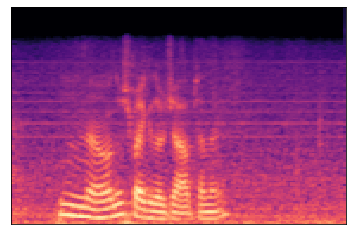

In [18]:
audio_file, sample_rate = librosa.load('/content/gdrive/My Drive/Public/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro04/Ses01F_impro04_M002.wav')

S = librosa.feature.melspectrogram(y=audio_file, sr=22000)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))

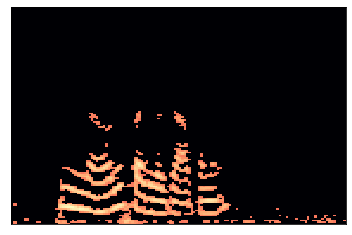

In [20]:
S = librosa.feature.melspectrogram(y=audio_file, sr=48000)

S[S < (np.average(S) / 1)] = 0
librosa.display.specshow(librosa.power_to_db(S, ref=np.max))

In [49]:
def loadGenerator():
  train_image_generator = ImageDataGenerator()
  train_data = train_image_generator.flow_from_directory(
      directory="image/train/",
      class_mode="categorical",
      batch_size=1,
      shuffle=True,
      target_size=(256, 256)
  )
    
  validation_image_generator = ImageDataGenerator()
  validation_data = validation_image_generator.flow_from_directory(
      directory="image/val/",
      class_mode="categorical",
      batch_size=1,
      shuffle=True,
      target_size=(256, 256)
  )

  test_image_generator = ImageDataGenerator()
  test_data = test_image_generator.flow_from_directory(
      directory="image/test/",
      batch_size=1,
      class_mode="categorical",
      shuffle=True,
      target_size=(256, 256)
  )

  return train_data, validation_data, test_data

# In generator
train_generator, validation_generator, test_generator = loadGenerator()

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

Found 840 images belonging to 4 classes.
Found 280 images belonging to 4 classes.
Found 288 images belonging to 4 classes.
(1480, 128, 50)
(498, 128, 50)
(508, 128, 50)


Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, 128, 50, 1)]      0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 128, 42, 16)       160       
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 128, 36, 32)       3616      
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 128, 32, 64)       10304     
_________________________________________________________________
flatten_24 (Flatten)         (None, 262144)            0         
_________________________________________________________________
dense_87 (Dense)             (None, 512)               134218240 
_________________________________________________________________
dense_88 (Dense)             (None, 256)               131

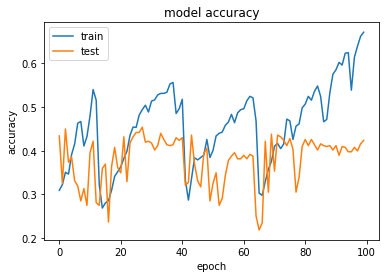

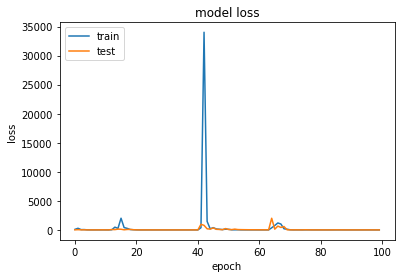

In [58]:
def plot_result(model, history):
  # list all data in history
  print(history.history.keys())

  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def save_model(model, filename):
  checkAndCreateDirectory("/content/model/test.txt")
  model.summary()

  plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

  with open("/content/model/" + filename + ".json", "w") as json_file:
    model_json = model.to_json()
    json_file.write(model_json)

def buildModel():
  model_input = Input(shape=(256, 256, 3))
  model_input = Input(shape=(128, 50, 1))

  model = Conv1D(16, kernel_size=9, strides=1)(model_input)
  model = Conv1D(32, kernel_size=7, strides=1)(model)
  model = Conv1D(64, kernel_size=5, strides=1)(model)

  # model = Conv1D(1, kernel_size=17, strides=1)(model)
  # model = Conv1D(1, kernel_size=13, strides=1)(model)
  # model = Conv1D(3, kernel_size=9, strides=1)(model)

  model = Flatten()(model)

  model = Dense(512)(model)
  model = Dense(256)(model)
  model = Dense(128)(model)

  model = Dense(512)(model)
  model = Dense(256)(model)
  model = Dense(128)(model)

  model = Dense(4, activation='softmax')(model)
  
#   model = Sequential()
#   eff = tf.keras.applications.EfficientNetB3(
#     weights=None,
#     classes=4,
#     input_shape=(256,256,3)
#   )

#   model.add(eff)

  # Model compile
  model = Model(inputs=[model_input], outputs=[model])
  model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])
  
  # Visualize & Save Model
  save_model(model, "struct_model")

  # Checkpoint
  basepath = '/content/model/weight_model'
  best_checkpoint = ModelCheckpoint(basepath +'_{epoch:02d}_{loss:.2f}_{accuracy:.2f}_{val_loss:.2f}_{val_accuracy:.2f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
  callback_list = [best_checkpoint]

  history = model.fit(
    x_train, 
    y_train, 
    validation_data=(x_val, y_val),
    batch_size=8, 
    epochs=100,
    callbacks=callback_list
  )

  # history = model.fit_generator(
  #   generator=train_generator,
  #   validation_data=validation_generator,
  #   epochs=100,
  #   callbacks=callback_list
  # )

  return model, history

# !sudo chmod 777 /mnt
!rm -rf model
# !rm -rf /mnt/model
# !rm -rf ../.local/share/Trash/files

# device = cuda.get_current_device()
# device.reset()

model, history = buildModel()
plot_result(model, history)

In [ ]:
def load_model(struct, weight):
  json_file = open("/mnt/model/" + struct + ".json", "r")
  loaded_model_json = json_file.read()
  json_file.close()

  loaded_model = model_from_json(loaded_model_json)
  loaded_model.load_weights("/mnt/model/" + weight + ".hdf5")
  loaded_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

  return loaded_model

lastCheckpoint = sorted(Path("/mnt/model").iterdir(), key=os.path.getmtime)[-1].stem
print("Model is " + lastCheckpoint)

loaded_model = load_model("struct_model", lastCheckpoint)

Model is weight_model_04_10.35_0.44_5.80_0.54


# Testing

In [ ]:
# train_loss, train_accuracy = loaded_model.evaluate(x_train, y_train)
# val_loss, val_accuracy = loaded_model.evaluate(x_val, y_val)
# test_loss, test_accuracy = loaded_model.evaluate(x_test, y_test)

# print(
#     ""
#     "\n"
#     "Train Loss: " + str(train_loss) + "\n"
#     "Train Accuracy: " + str(train_accuracy * 100) + "%\n"
#     "\n"
#     "Validation Loss: " + str(val_loss) + "\n"
#     "Validation Accuracy: " + str(val_accuracy * 100) + "%\n"
#     "\n"
#     "Test Loss: " + str(test_loss) + "\n"
#     "Test Accuracy: " + str(test_accuracy * 100) + "%"
#     "")

In [ ]:
loss, accuracy = loaded_model.evaluate_generator(generator=test_data)
print(
    ""
    "Prediction Loss: %2d\n"
    "Prediction Accuracy: %2d%%"
    ""
    % (loss, accuracy * 100))

Found 336 images belonging to 4 classes.
Prediction Loss:  6
Prediction Accuracy: 51%


# Analysis

In [ ]:
target_names = ['neu', 'ang', 'hap', "sad"]

Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

y_decoded = []
for pred in y_test:
  decoded = np.where(pred == 1)[0][0]
  y_decoded.append(decoded)

print('Confusion Matrix')
print(target_names)
print(confusion_matrix(y_decoded, y_pred))
print(x_test.shape)

print('\n\nClassification Report')
print(classification_report(y_decoded, y_pred, target_names=target_names))

Confusion Matrix
['neu', 'ang', 'hap', 'sad']
[[ 3  2  7  3]
 [ 2  6  6  3]
 [ 7  3  5  3]
 [ 3  0  4 10]]
(67, 128, 50)


Classification Report
              precision    recall  f1-score   support

         neu       0.20      0.20      0.20        15
         ang       0.55      0.35      0.43        17
         hap       0.23      0.28      0.25        18
         sad       0.53      0.59      0.56        17

    accuracy                           0.36        67
   macro avg       0.37      0.35      0.36        67
weighted avg       0.38      0.36      0.36        67



In [ ]:
target_names = ['neu', 'ang', 'hap', "sad"]

Y_pred = model.predict_generator(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))

print('\n\nClassification Report')
print(classification_report(test_data.classes, y_pred, target_names=target_names))